In [46]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

def get_data(path, time_start=0, time_end=np.Infinity):   
    treelets = pd.read_csv(os.path.join(path, "treelets.csv"))
    summary = pd.read_csv(os.path.join(path, "summary.csv"))

    num_rays = (treelets[((treelets.timestamp >= time_start) & (treelets.timestamp < time_end)) | (treelets.timestamp == treelets.timestamp.min())]
                        .sort_values('treeletId')
                        .groupby('treeletId')
                        .agg({'raysDequeued': 'sum'})
                        .raysDequeued
                        .to_numpy())

    nodes_per_ray = (summary.sort_values('treeletId')
                            .groupby('treeletId')
                            .agg({'trace': 'sum',
                                  'visited': 'sum'}))
    
    nodes_per_ray = (nodes_per_ray.visited / nodes_per_ray.trace).to_numpy()
    return num_rays, nodes_per_ray

def generate_static0(num_rays, nodes_per_ray):
    average_ray_size = 250         # 500 bytes
    average_bandwidth = 50_000_000 # 25 MB/s receive

    cost_bw = average_ray_size / average_bandwidth
    cost_compute = 0.25e-6 # 0.5us per node visited
    
    weights = np.nan_to_num(np.maximum(cost_bw * num_rays,
                                       cost_compute * nodes_per_ray * num_rays))

    return weights

def generate_assignment(static0, max_workers):
    weights = static0.copy()
    treelet_count = len(weights)

    assignment = np.zeros((treelet_count,), dtype=int)
    idx = list(range(treelet_count))
    idx = sorted(idx, key=lambda x: weights[x])
    
    for i in idx:
        if np.sum(weights) == 0:
            break
        worker_count = np.ceil(weights[i] / np.sum(weights) * max_workers)
        worker_count = max(worker_count, 1)
        assignment[i] = worker_count
        
        weights[i] = 0
        max_workers -= worker_count
        
    return assignment

In [ ]:
max_workers = 2000
base_assignment = generate_assignment(generate_static0(*get_data("/home/sadjad/temp/r2t2/moana9-beachcam")),
                                      max_workers)

In [128]:
def plot_assignment(treelet_id, start_time, end_time, resolution):
    res = []
    
    base_assignment = generate_assignment(generate_static0(*get_data("/home/sadjad/temp/r2t2/moana9-beachcam")),
                                         2000)
    
    for start in range(start_time, end_time, resolution):
        assignment = generate_assignment(generate_static0(*get_data("/home/sadjad/temp/r2t2/moana9-beachcam",
                                                                    time_start=start, time_end=start + resolution)),
                                         2000)
        res += [assignment[treelet_id]]
        
    plt.plot(list(range(start_time, end_time, resolution))[1:], np.array(res[1:]), '-*')
    plt.axhline(y=base_assignment[treelet_id], color='r', linestyle='--')

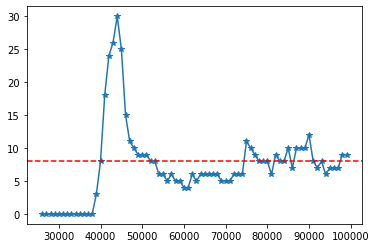

In [133]:
plot_assignment(793, 25000, 100000, 1000)

In [68]:
np.where(base_assignment > 1)

(array([  0, 456, 638, 729, 733, 736, 737, 740, 741, 744, 748, 752, 754,
        762, 764, 767, 772, 773, 775, 777, 778, 779, 780, 783, 785, 791,
        792, 793, 794, 795, 798, 800, 801, 804, 805, 806, 808]),)